## Test real signal

In [1]:
import scipy
import scipy.io as sio
import scipy.fftpack
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch

In [2]:
# Highpass
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-filt_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    y1 = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        y1.append(edf_epoch.readSignal(sig))
    y1 = np.vstack(y1)

In [4]:
y1.shape, idx

((148, 48000), 71)

In [5]:
# Detrend
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-detrend_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    y2 = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        y2.append(edf_epoch.readSignal(sig))
    y2 = np.vstack(y2)
y2.shape, idx

((148, 48000), 71)

In [6]:
# Demean
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-demean_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    y3 = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        y3.append(edf_epoch.readSignal(sig))
    y3 = np.vstack(y3)
y3.shape, idx

((148, 48000), 71)

In [8]:
# Original
import pyedflib
edf_epoch_file = '/scratch/mcesped/Results/tmp_seeg/sub-EPL31LHS0026_ses-V02SE06_task-full_rec-dn_run-01_clip-01_ieeg.edf'
with pyedflib.EdfReader(edf_epoch_file) as edf_epoch:
    idx = edf_epoch.getSignalLabels().index('LPIn2')
    orig_y = []
    for sig in range(len(edf_epoch.getSignalLabels())):
        orig_y.append(edf_epoch.readSignal(sig))
    orig_y = np.vstack(orig_y)
orig_y.shape, idx

((148, 48000), 71)

In [9]:


f, w = welch(y1, fs=fs, nperseg=int(length_segment*fs))
w.shape

(148, 301)

### Statistics

In [28]:
# Create dict
length_segment = 3.0
fs = 200

total_dict = {
    'Category': [],
    'Frequency component (Hz)': [],
    'Magnitude ($\mu$V$^2$/Hz)': [],
    'chn': []
}
for signals, method in zip((y1,y2,y3,orig_y),("Highpass Filtering", "Linear Detrending", "Demeaning", "Original")):
    # Transform to freq domain
    f, w = welch(signals, fs=fs, nperseg=int(length_segment*fs))
    total_dict['Category'] += [method for i in range(4*w.shape[0])]
    for chn in range(w.shape[0]):
        total_dict['chn'] += [chn for i in range(4)]
        total_dict['Frequency component (Hz)'] += np.round(f[0:4],2).tolist()
    total_dict['Magnitude ($\mu$V$^2$/Hz)'] += w[:,0:4].flatten().tolist()

df = pd.DataFrame(total_dict)
df.head()

,Category,Frequency component (Hz),Magnitude ($\mu$V$^2$/Hz),chn
0,Highpass Filtering,0.00,172.948875,0
1,Highpass Filtering,0.33,545.080198,0
2,Highpass Filtering,0.67,406.196079,0
3,Highpass Filtering,1.00,269.638766,0
4,Highpass Filtering,0.00,158.693142,1


In [33]:
df.loc[df.chn==0]

,Category,Frequency component (Hz),Magnitude ($\mu$V$^2$/Hz),chn
0,Highpass Filtering,0.00,172.948875,0
1,Highpass Filtering,0.33,545.080198,0
2,Highpass Filtering,0.67,406.196079,0
3,Highpass Filtering,1.00,269.638766,0
592,Linear Detrending,0.00,280.814428,0
593,Linear Detrending,0.33,1165.483196,0
594,Linear Detrending,0.67,442.421941,0
595,Linear Detrending,1.00,277.402952,0
1184,Demeaning,0.00,280.820877,0
1185,Demeaning,0.33,1165.206182,0


In [13]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import permutation_test
from itertools import combinations
from statsmodels.stats.multitest import fdrcorrection
from statannotations.Annotator import Annotator

In [ ]:
# Generate pairs
elements = df.Category.unique()

# Generate combinations of length 2 without repetition
combinations_without_repetition = list(combinations(elements, 2))

# Run permutation with median
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
    # return np.median(x, axis=axis) - np.median(y, axis=axis)


pairs=[]
p_vals = []
for metric in df['Frequency component (Hz)'].unique():
    p_vals_tmp = []
    for element_1, element_2 in combinations_without_repetition:
        # print(f'\n Comparison between {net_1} and {net_2}\n')
        x = df.loc[(df['Frequency component (Hz)'] == metric).astype(bool) & (df.Category == element_1).astype(bool),'Magnitude ($\mu$V$^2$/Hz)'].values
        y = df.loc[(df['Frequency component (Hz)'] == metric).astype(bool) & (df.Category == element_2).astype(bool),'Magnitude ($\mu$V$^2$/Hz)'].values 
        base = statistic(x, y, 0) # Small network has worst performance
        # Permutation testing
        res = permutation_test((x, y), statistic, vectorized=True,
                           n_resamples=100000, alternative='less' if base<0 else 'greater')
        # print('Real diff',res.statistic)
        # print('p-val: ', res.pvalue)
        p_vals_tmp.append(res.pvalue)
        pairs.append([(metric, element_1), (metric, element_2)])
    # Correct them
    significance, corr_p_vals = fdrcorrection(p_vals_tmp)
    p_vals += corr_p_vals.tolist()

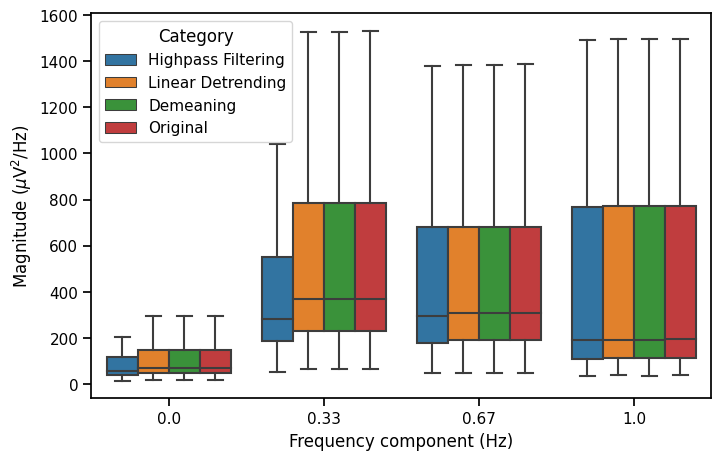

In [36]:
# Plot params
plotting_parameters = {
    'data': df,
    'y': "Magnitude ($\mu$V$^2$/Hz)",
    'x': "Frequency component (Hz)",
    'hue':'Category',
    'showfliers': False
}
# sns.boxplot(data=df_tmp, x="Value", y="Metric", hue='Name_Net')
with sns.plotting_context('notebook', font_scale = 1):
    # Create new plot
    ax = plt.subplots(ncols=1, nrows=1, figsize=(8,5))
    # Plot with seaborn
    ax = sns.boxplot(**plotting_parameters, showmeans=False,
            meanprops={'marker':'o',
                       'markerfacecolor':'white', 
                       'markeredgecolor':'black',
                       'markersize':'8'})
    # Label and show
    plt.show()

#### Plots comparison

In [10]:
import matplotlib
matplotlib.rc_file_defaults()
font = {'size'   : 22}

matplotlib.rc('font', **font)

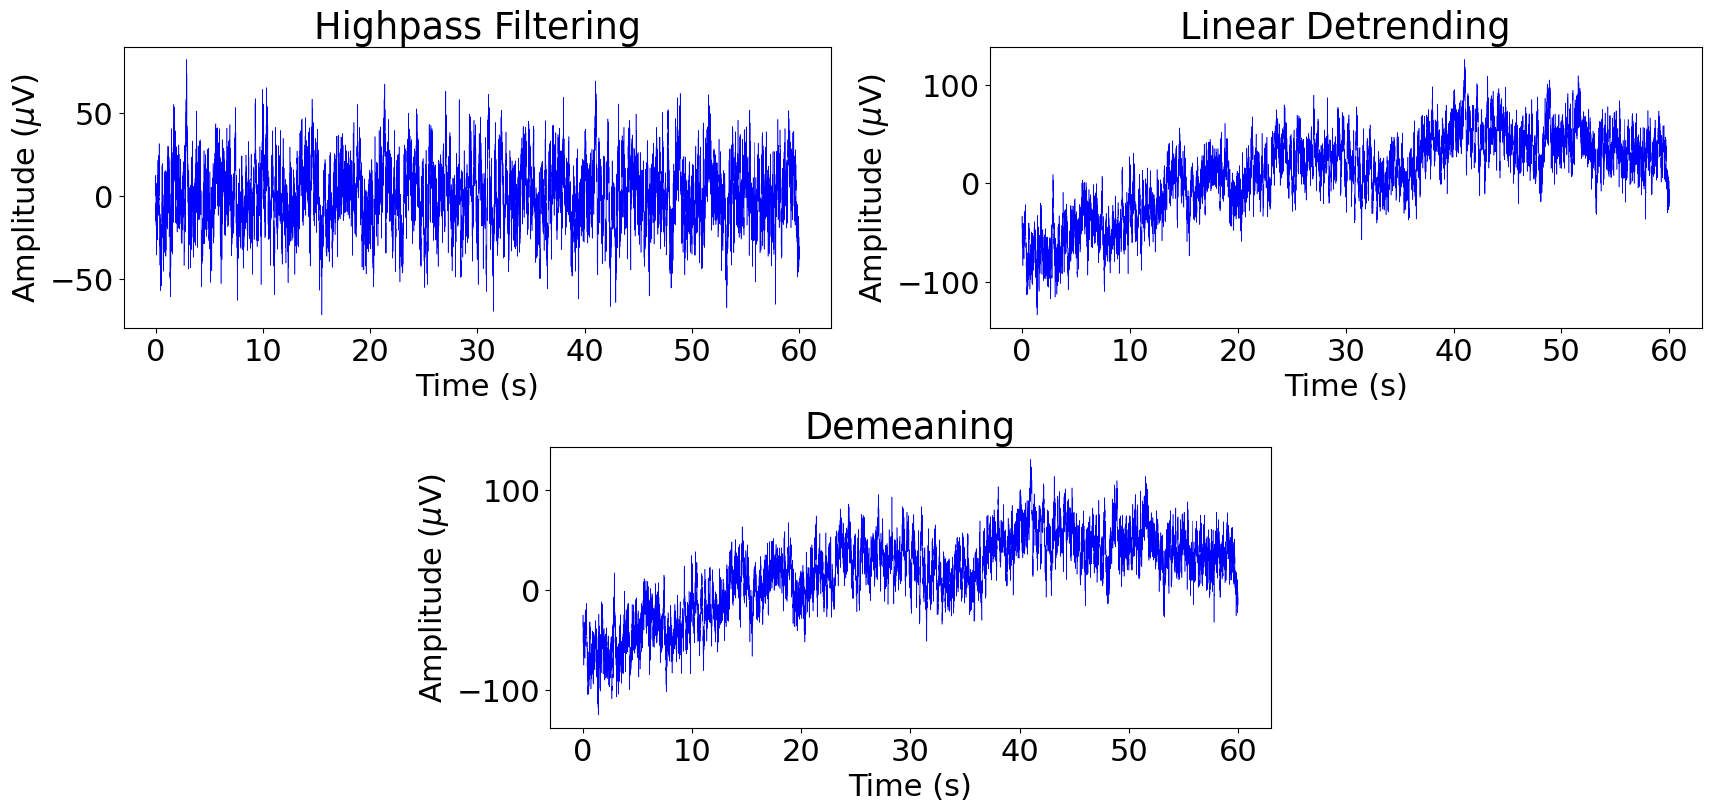

In [28]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,8))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

fs=200

time = (np.arange(0,len(y1))/fs)[:60*fs]

ax1.plot(time, y1[:60*fs], 'b', linewidth=0.4)
ax1.set_title('Highpass Filtering')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude ($\mu$V)')

ax2.plot(time, y2[:60*fs], 'b', linewidth=0.4)
ax2.set_title('Linear Detrending')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude ($\mu$V)')

ax3.plot(time, y3[:60*fs], 'b', linewidth=0.4)
ax3.set_title('Demeaning')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude ($\mu$V)')

plt.show()

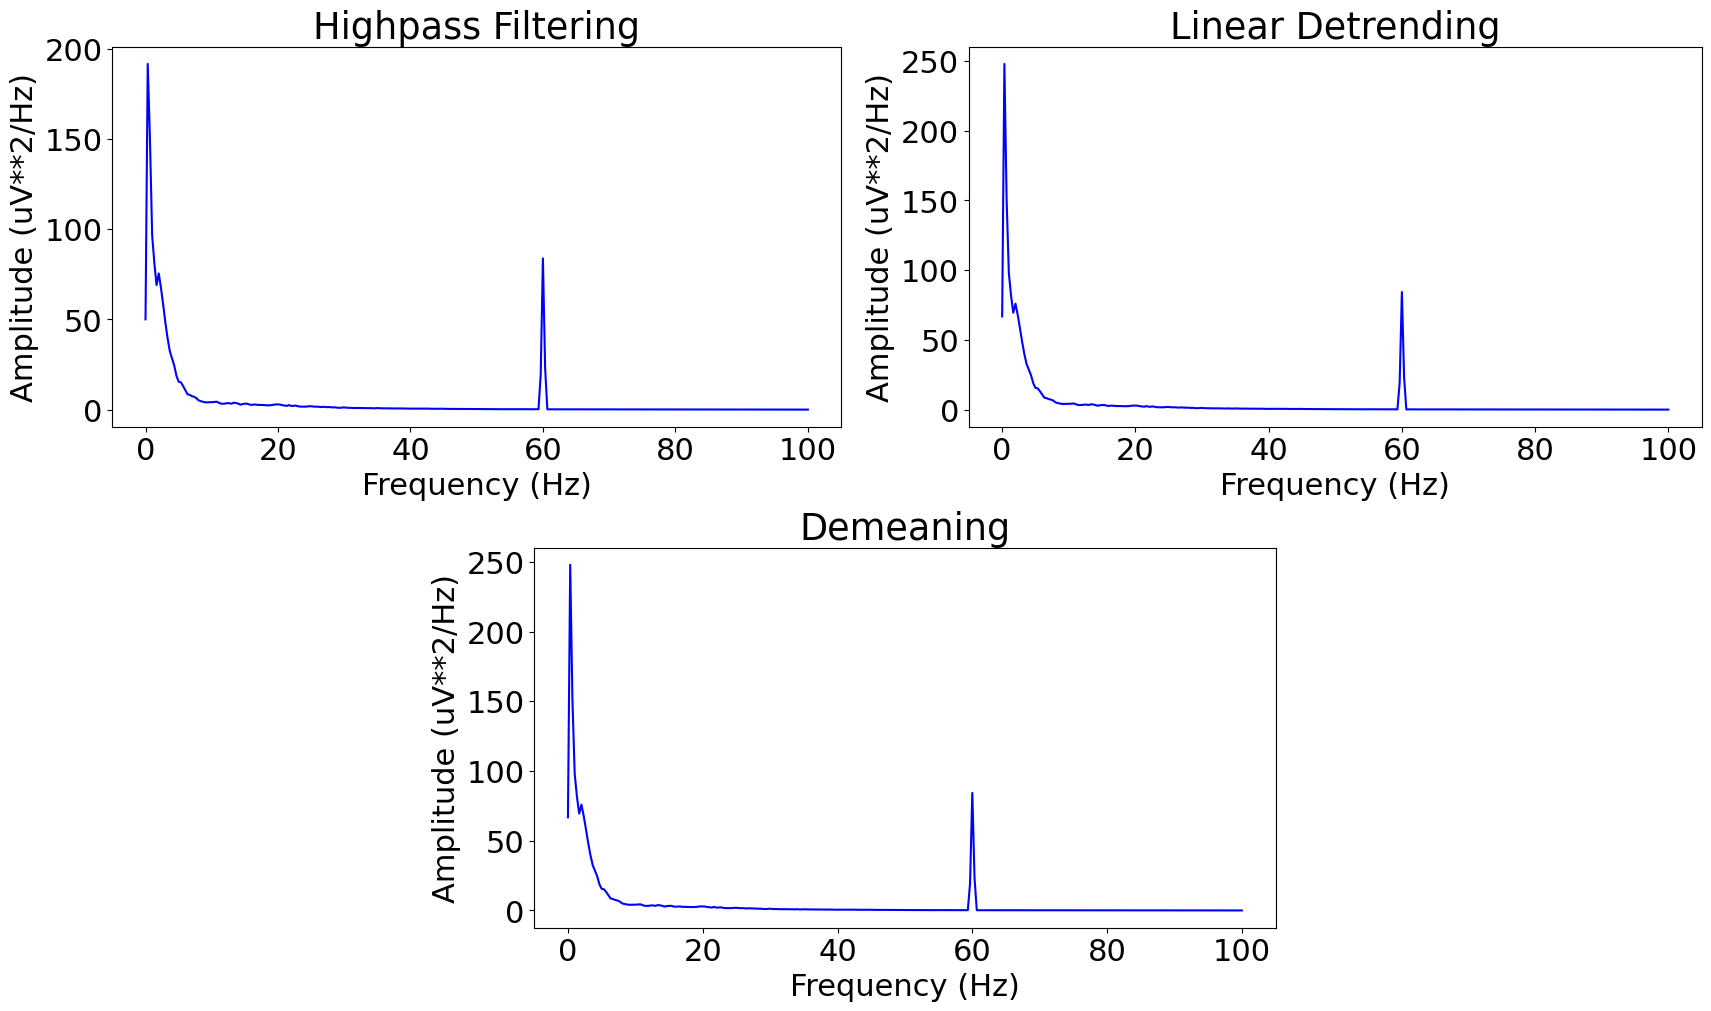

In [25]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2,4)
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0

f, w = welch(y1, fs=fs, nperseg=int(length_segment*fs))
ax1.plot(f, w, 'b')
ax1.set_title('Highpass Filtering')
ax1.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

f, w = welch(y2, fs=fs, nperseg=int(length_segment*fs))
ax2.plot(f, w, 'b')
ax2.set_title('Linear Detrending')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

f, w = welch(y3, fs=fs, nperseg=int(length_segment*fs))
ax3.plot(f, w, 'b')
ax3.set_title('Demeaning')
ax3.set_xlabel('Frequency (Hz)')
ax3.set_ylabel('Amplitude ($\mu$V$^2$/Hz)')

plt.show()

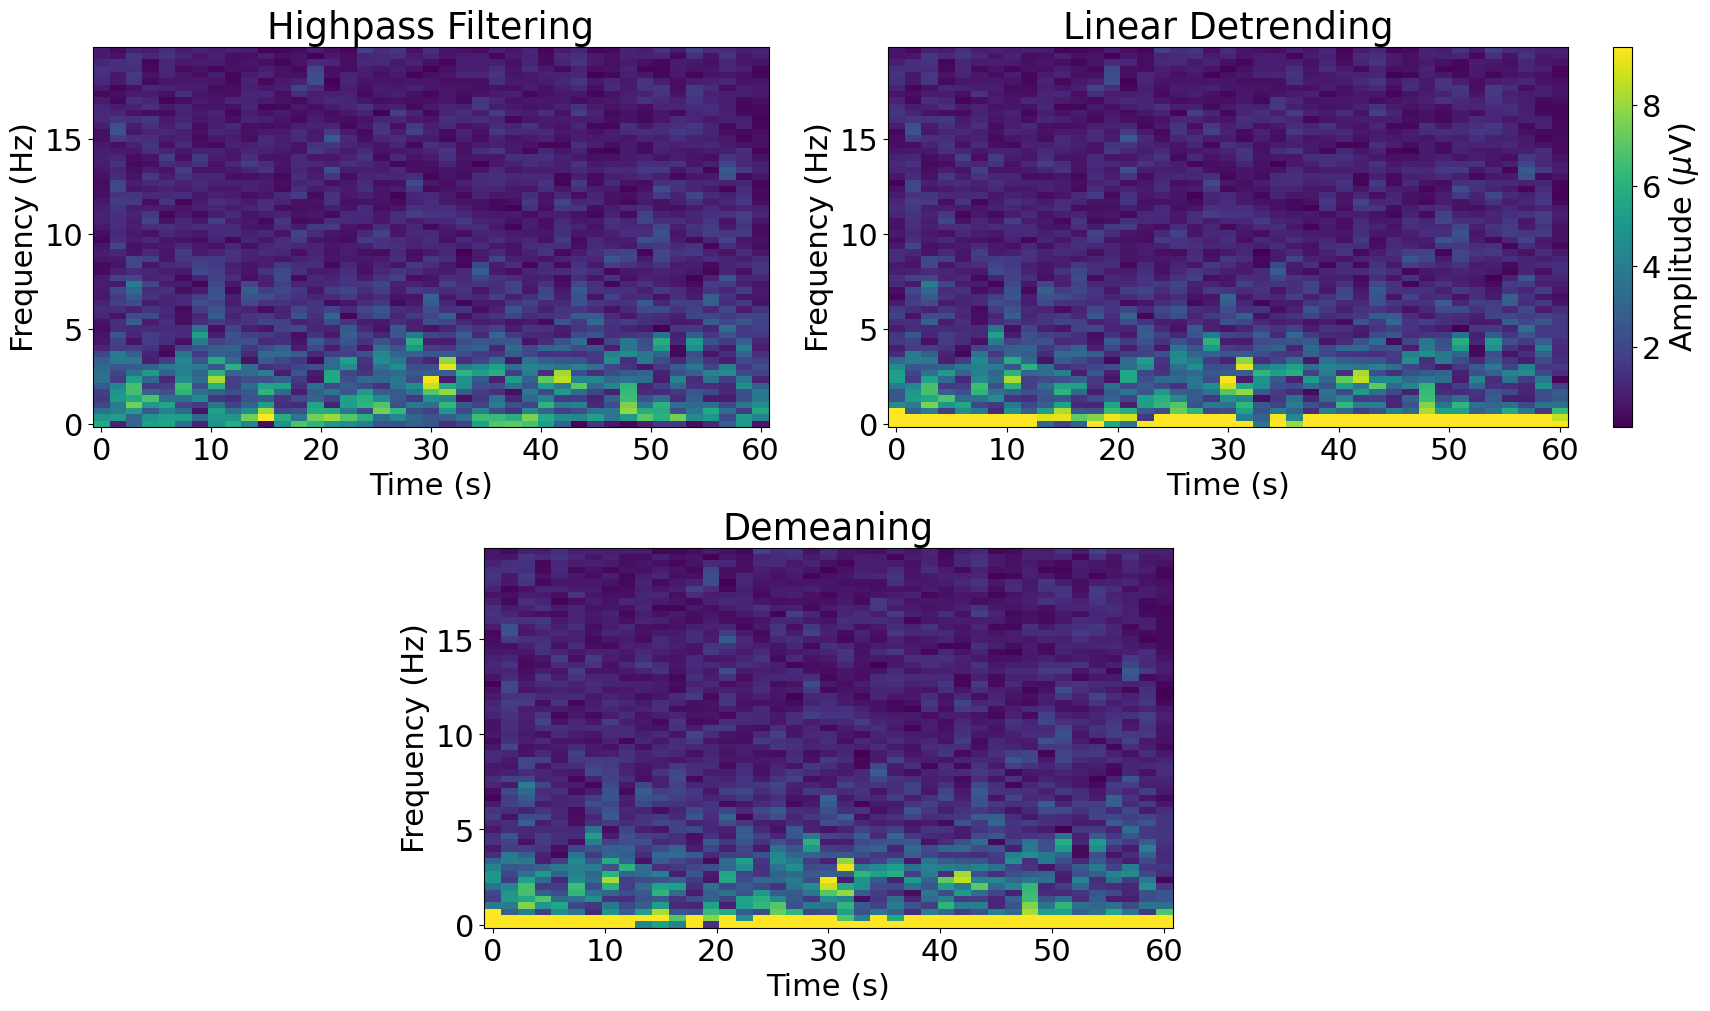

In [30]:
# Comparison against ground truth
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(17,10))
gs = fig.add_gridspec(2, 4, width_ratios=[1, 1, 1, 1])  # Adjust width ratios if needed
# gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2], )
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, 1:3])

length_segment = 3.0
f, t, Zxx_1 = scipy.signal.stft(y1[:60*fs], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_2 = scipy.signal.stft(y2[:60*fs], fs=fs, nperseg=length_segment*fs)
f, t, Zxx_3 = scipy.signal.stft(y3[:60*fs], fs=fs, nperseg=length_segment*fs)

# Plot between 50 and 70 Hz
f_max = np.argmin(np.abs(f-20))
f_min = np.argmin(np.abs(f-0))
Zxx_1 = Zxx_1[f_min:f_max,:]
Zxx_2 = Zxx_2[f_min:f_max,:]
Zxx_3 = Zxx_3[f_min:f_max,:]

vmin=min(np.min(np.abs(Zxx_1)), np.min(np.abs(Zxx_2)), np.min(np.abs(Zxx_3)))
vmax=min(np.max(np.abs(Zxx_1)), np.max(np.abs(Zxx_2)), np.max(np.abs(Zxx_3)))

ax1.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_1), vmin=vmin, vmax=vmax)
ax1.set_title('Highpass Filtering')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Frequency (Hz)')

ax2.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_2), vmin=vmin, vmax=vmax)
ax2.set_title('Linear Detrending')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Frequency (Hz)')

c3 = ax3.pcolormesh(t, f[f_min:f_max], np.abs(Zxx_3), vmin=vmin, vmax=vmax)
ax3.set_title('Demeaning')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Frequency (Hz)')
plt.colorbar(c3, ax=ax2, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot
# plt.colorbar(c3, ax=ax3, label='Amplitude ($\mu$V)')  # Add colorbar for the last subplot


# plt.tight_layout()
plt.show()